In [1]:
RANDOM_SEED = 42
SAMPLE_DATA_PERCENTAGE = 1.0
MIN_IOU_REQUIRED = 0.7  # The minimum IOU required to be a good detection (ie higher is more strict)
NUM_PROPOSALS = 300
CHECKPOINT_DIR = './idd_car_drop_checkpoints'

%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import torch as t
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
from utils.config import opt
from utils.idd_utils import get_annotations
from model.utils.bbox_tools import bbox_iou

from data.dataset import Dataset, TestDataset, KittiDataset
from torch.utils.data import DataLoader
from utils.vis_tool import vis_bbox, vis_image
from utils.idd_utils import IndiaDrivingDataset
from ood_metrics import auroc, plot_roc, calc_metrics
from sklearn import svm
import pickle
import itertools
import torch
from model.faster_rcnn import nograd
from data.dataset import preprocess
from utils.mahalanobis import Mahal_Dist


import warnings
warnings.filterwarnings(action='once')

np.random.seed(RANDOM_SEED)

In [2]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
idd_data_dir = "/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/"

kitti_train_dataset = KittiDataset(opt, split='train')
kitti_val_dataset = KittiDataset(opt, split='val')
idd_val_dataset = IndiaDrivingDataset(idd_data_dir, split='val')

kitti_train_samples = round(len(kitti_train_dataset) * SAMPLE_DATA_PERCENTAGE)
kitti_val_samples = round(len(kitti_val_dataset) * SAMPLE_DATA_PERCENTAGE)
idd_val_samples = round(len(idd_val_dataset) * SAMPLE_DATA_PERCENTAGE)

KITTI_TRAIN_TO_USE = np.random.choice(kitti_train_samples, kitti_train_samples, replace=False)
KITTI_VAL_TO_USE = np.random.choice(kitti_val_samples, kitti_val_samples, replace=False)
IDD_VAL_TO_USE = np.random.choice(idd_val_samples, idd_val_samples, replace=False)


# Datasets after sampling a portion of them
kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, KITTI_TRAIN_TO_USE)
kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, KITTI_VAL_TO_USE)
idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, IDD_VAL_TO_USE)

In [3]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn, visdom=False).cuda()

# Load model trained with caffe pretrained model

In [4]:
%ls ./checkpoints/cars_drop/

fasterrcnn_11060017_0.7454640828611436  fasterrcnn_11061638_0.7497252402944325
fasterrcnn_11061427_0.7282598515502949  fasterrcnn_11061705_0.7526206908232453
fasterrcnn_11061454_0.733123502219126   fasterrcnn_11062316_0.7550167879591324
fasterrcnn_11061507_0.7394557961451338


In [5]:
save_dir = './checkpoints/cars_drop'
trainer.load(os.path.join(save_dir, 'fasterrcnn_11062316_0.7550167879591324'))
trainer.faster_rcnn.eval()

FasterRCNNVGG16(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

# Extract classifier features

In [6]:
string_dt = h5py.string_dtype(encoding='utf-8')
feature_layer_sizes = (512, 4096, 4096)

In [7]:
def extract_kitti_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                
                
def extract_idd_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)

    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                

def show_max_ious_dist(data_file):
    """
    Given a data file generated by one of the feature_extractor functions, show the distribution 
    of IOUs with the gt data.
    """
    total_false_positives = 0
    all_max_ious = np.array([])

    with h5py.File(data_file, "r") as f:
        dset_length = len(f)
        for i in range(dset_length):
            max_ious = f[str(i)]["pred_max_ious"][()]

            false_positives = (max_ious < MIN_IOU_REQUIRED)
            total_false_positives += sum(false_positives)

            all_max_ious = np.concatenate((all_max_ious, max_ious), axis=0)

    plt.hist(all_max_ious, bins=50)
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()

    total_detections = len(all_max_ious)
    print("Total false positives (< %.2f) IoU: %d" % (MIN_IOU_REQUIRED, total_false_positives))
    print("Total detections: %d" % (total_detections))
    print("Total false positives (< %.2f) IoU: %f%%" % (MIN_IOU_REQUIRED, float(total_false_positives)/float(total_detections)*100))
    

def read_features(save_file, feature_idx):
    """
    Read the features from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        for i in trange(len(f)):
            d = f[str(i)]
            features = d["pred_features_%d" % feature_idx][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y


def read_scores(save_file):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        for i in trange(len(f)):
            d = f[str(i)]
            features = d["pred_scores"][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y

# Extract classifier features

#### Kitti Train

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


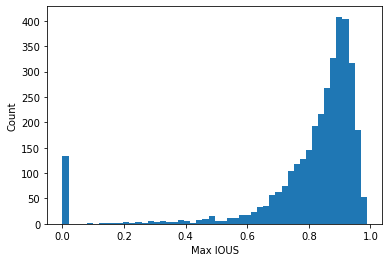

Total false positives (< 0.70) IoU: 461
Total detections: 3429
Total false positives (< 0.70) IoU: 0.134442%


In [25]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")

if False:
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### Kitti Val

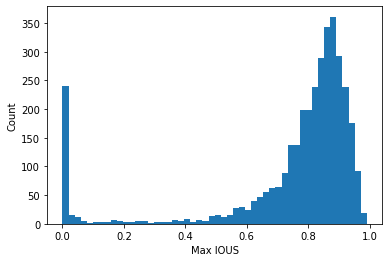

Total false positives (< 0.70) IoU: 724
Total detections: 3578
Total false positives (< 0.70) IoU: 0.202348%


In [26]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

if False:
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### IDD Val

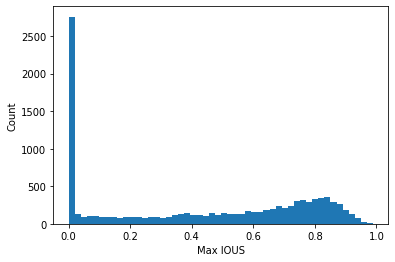

Total false positives (< 0.70) IoU: 6930
Total detections: 10225
Total false positives (< 0.70) IoU: 0.677751%


In [27]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

if False:
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

## One-Class SVM on Kitti features (Conv-512 layer)

In [70]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 0)

In [71]:
kitti_train_X.shape

(3429, 4096)

In [29]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-conv-512-one-class.pickle")
    
training_mask = kitti_train_y.astype(np.bool)

print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)

if :
    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])
    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

Collected 2959 train samples of size 512
7


/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### Kitti Train

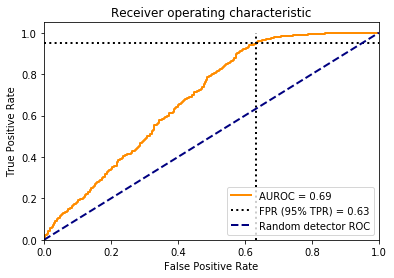

{'fpr_at_95_tpr': 0.6319148936170212, 'detection_error': 0.34028999158715206, 'auroc': 0.6857952298433196, 'aupr_in': 0.916052607198981, 'aupr_out': 0.4502254712544204}


In [30]:
kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)
print(calc_metrics(kitti_train_novelty_scores, kitti_train_y))

#### Kitti Val

In [31]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 0)

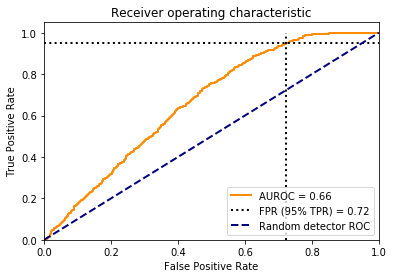

{'fpr_at_95_tpr': 0.7211538461538461, 'detection_error': 0.385138326585695, 'auroc': 0.663225371120108, 'aupr_in': 0.856212978259847, 'aupr_out': 0.4657407273055684}


In [32]:
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
plot_roc(kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [33]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 0)

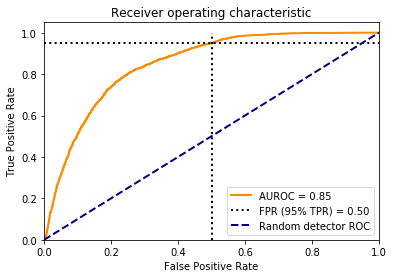

{'fpr_at_95_tpr': 0.5022560631697688, 'detection_error': 0.2760242971450504, 'auroc': 0.8479350955181357, 'aupr_in': 0.6536826486094263, 'aupr_out': 0.9309264077796383}


In [34]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

## One-Class SVM on Kitti features (FC-4096 (#1) layer) 

In [35]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 1)

In [ ]:
kitti_train_X.shape

In [36]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-fc-4096-1-one-class.pickle")
    
training_mask = kitti_train_y.astype(np.bool)

print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)

if False:
    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])

    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

Collected 2959 train samples of size 4096


/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


10


#### Kitti Train

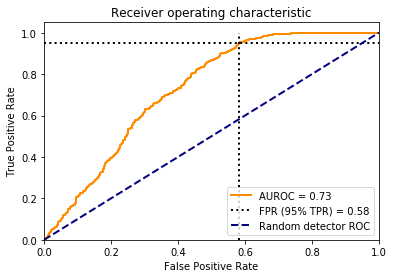

{'fpr_at_95_tpr': 0.5829787234042553, 'detection_error': 0.3159908824861763, 'auroc': 0.726973603790815, 'aupr_in': 0.9205673404680601, 'aupr_out': 0.5224069075998792}


In [37]:
kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)
print(calc_metrics(kitti_train_novelty_scores, kitti_train_y))

#### Kitti Val

In [38]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 1)

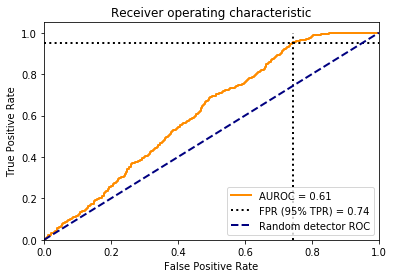

{'fpr_at_95_tpr': 0.7445054945054945, 'detection_error': 0.3950597647966069, 'auroc': 0.6144148833622518, 'aupr_in': 0.83507788810391, 'aupr_out': 0.41827906974436857}


In [39]:
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
plot_roc(kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [40]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 1)

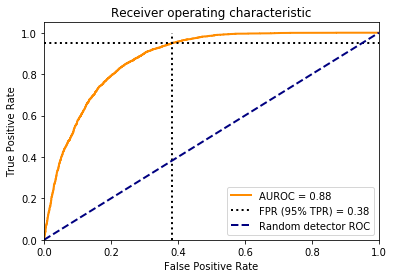

{'fpr_at_95_tpr': 0.3826847151720248, 'detection_error': 0.2162386231461784, 'auroc': 0.8790782005285871, 'aupr_in': 0.7159746644575848, 'aupr_out': 0.9478091381988323}


In [41]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

# Max Softmax

#### Kitti train

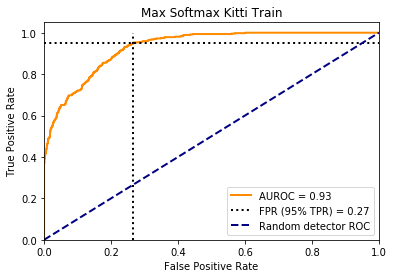

{'fpr_at_95_tpr': 0.26596823251098345, 'detection_error': 0.1574522013618747, 'auroc': 0.9301305789046039, 'aupr_in': 0.7594323278333361, 'aupr_out': 0.987865777310315}


In [42]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_scores(save_path)

kitti_train_novelty_scores = -kitti_train_X
plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="Max Softmax Kitti Train")
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val

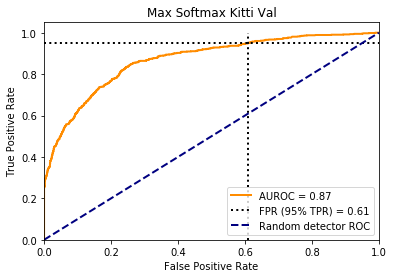

{'fpr_at_95_tpr': 0.6091228070175438, 'detection_error': 0.32928667823404667, 'auroc': 0.8674539714671294, 'aupr_in': 0.712957661082286, 'aupr_out': 0.9541819368925385}


In [43]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_scores(save_path)

kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="Max Softmax Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

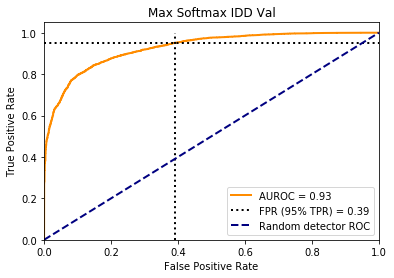

{'fpr_at_95_tpr': 0.3900414937759336, 'detection_error': 0.21997844570353361, 'auroc': 0.9261326537060051, 'aupr_in': 0.9665348763939772, 'aupr_out': 0.8515422138374007}


In [44]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_scores(save_path)

idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="Max Softmax IDD Val")
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

# Mahalanobis

#### Kitti train

In [26]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 4)

In [27]:
kitti_train_X.shape

(3429, 4096)

In [28]:
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis.h5")

if False:
    # Take features from good detections only
    kitti_mahalanobis_features = kitti_train_X[kitti_train_y.astype(np.bool)]
    
    # Everything is labelled 0 because we're just doing single class detection
    kitti_mahalanobis_labels = np.zeros((len(kitti_mahalanobis_features)))
    
    md = Mahal_Dist(kitti_mahalanobis_features, kitti_mahalanobis_labels)
    md.save(mahal_model_name)
    
else:
    md = Mahal_Dist.load(mahal_model_name)

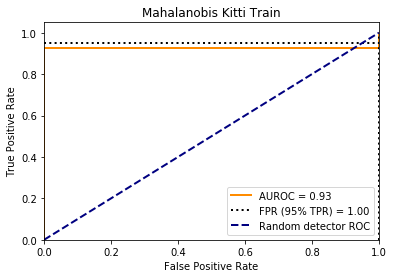

{'fpr_at_95_tpr': 1.0, 'detection_error': 0.5, 'auroc': 0.9276595744680851, 'aupr_in': 0.9372634544228792, 'aupr_out': 0.9485490828380501}


In [29]:
kitti_train_novelty_scores = md(kitti_train_X)
plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="Mahalanobis Kitti Train")
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val

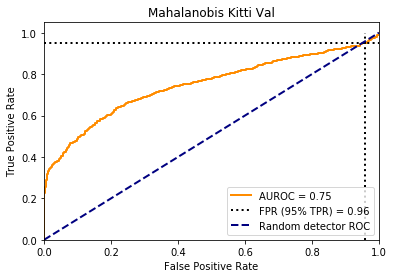

{'fpr_at_95_tpr': 0.9585964912280702, 'detection_error': 0.5, 'auroc': 0.7473168498168499, 'aupr_in': 0.6020073024359117, 'aupr_out': 0.875045841565008}


In [66]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 4)

kitti_val_novelty_scores = md(kitti_val_X)
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="Mahalanobis Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

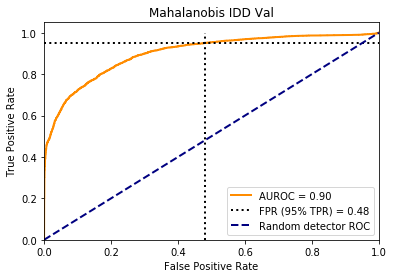

{'fpr_at_95_tpr': 0.47973188637089054, 'detection_error': 0.2647531400269568, 'auroc': 0.9009289518325473, 'aupr_in': 0.9558342189103664, 'aupr_out': 0.754100063113365}


In [77]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 4)

idd_val_novelty_scores = md(idd_val_X)
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="Mahalanobis IDD Val")
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

## ODIN

In [40]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
# temperatures = np.array([1])
temperatures = np.array([1000])

epsilons = np.linspace(0, 0.004, 21)
# epsilons = np.linspace(0, 0.004, 5)
# epsilons = np.array([0.0034])

odin_params = list(itertools.product(epsilons, temperatures))

#### Kitti train

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)



ODIN Kitti Train e=0.000000, T=1000


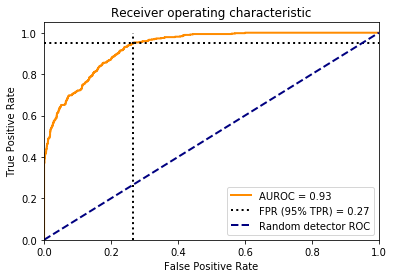

--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
BrokenPipeError: [Errno 32] Broken pipe
--- Logging error ---
--- Logging error ---
Call stack:
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logg

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_f

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded =

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "<ipython-input-9-f24b5d42c9dd>", line 5, in <module>
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "<ipython-input-7-ef4a010a3feb>", line 13

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "<ipython-input-9-f24b5d42c9dd>", line 5, in <module>
    extract_kitti_features(kitti_train_dat

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 150, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit

  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 281, in <module>
    class DibImageFile(BmpImageFile):
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/e

  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '448f67cb-95a61b0e85f427794b823860', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '010ccc70-41e494d4b4a7e93ffd05445c', 'date': datetime.datetime(2019, 11, 28, 22, 16, 34, 756838, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '448f67cb-95a61b0e85f427794b823860', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'a

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GifImagePlugin.py", line 401, in <module>
    def _write_single_frame(im, fp, palette):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/pytho


ODIN Kitti Train e=0.000200, T=1000


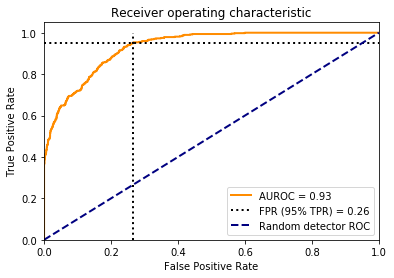


ODIN Kitti Train e=0.000400, T=1000


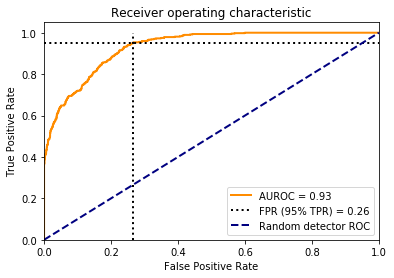


ODIN Kitti Train e=0.000600, T=1000


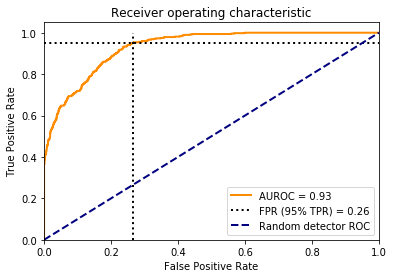


ODIN Kitti Train e=0.000800, T=1000


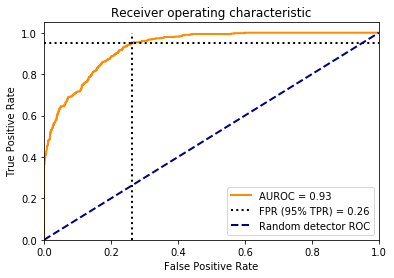


ODIN Kitti Train e=0.001000, T=1000


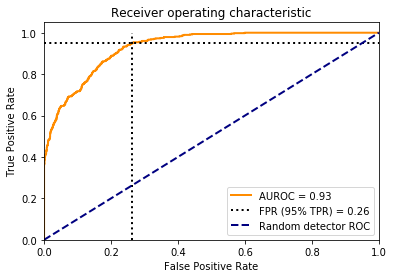


ODIN Kitti Train e=0.001200, T=1000


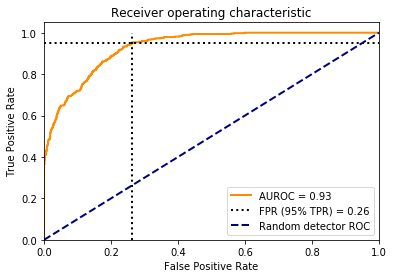


ODIN Kitti Train e=0.001400, T=1000


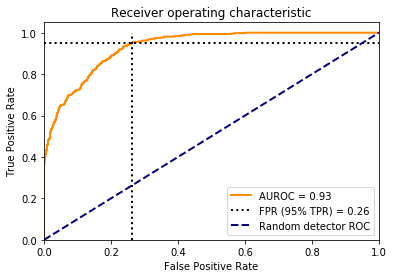


ODIN Kitti Train e=0.001600, T=1000


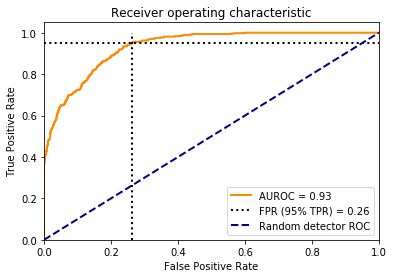


ODIN Kitti Train e=0.001800, T=1000


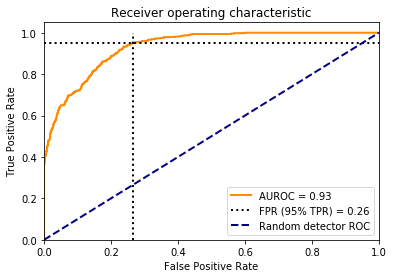


ODIN Kitti Train e=0.002000, T=1000


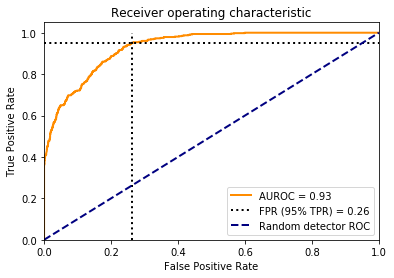


ODIN Kitti Train e=0.002200, T=1000


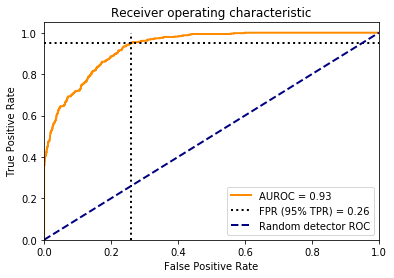


ODIN Kitti Train e=0.002400, T=1000


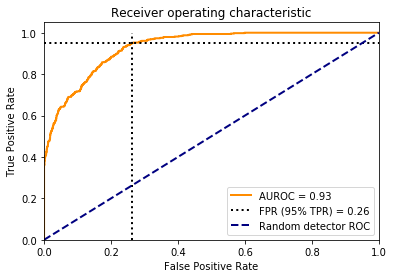


ODIN Kitti Train e=0.002600, T=1000


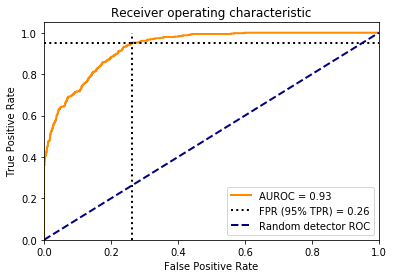


ODIN Kitti Train e=0.002800, T=1000


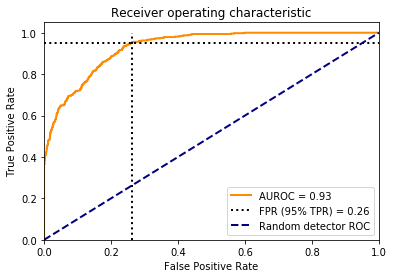


ODIN Kitti Train e=0.003000, T=1000


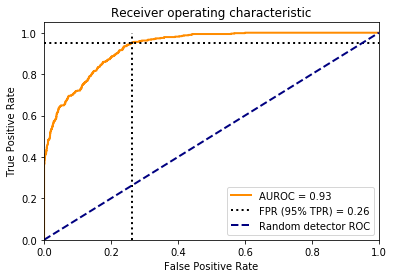


ODIN Kitti Train e=0.003200, T=1000


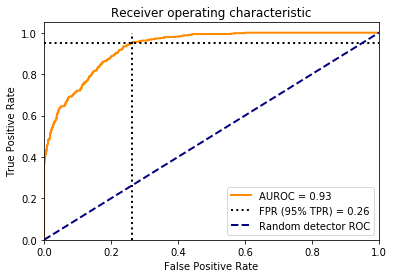


ODIN Kitti Train e=0.003400, T=1000


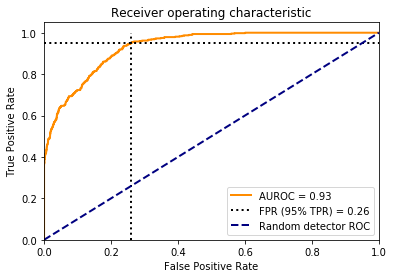

--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in e

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 128, in _run_after_forkers
    items = list(_afterfork_registry.items())
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/weakref.py", line 217, in items
    yield k, v
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packag

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/e

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "<ipython-input-9-f24b5d42c9dd>", line 5, in <module>
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packag

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 150, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler,

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<frozen importlib._boo

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap>", line 967, in _fin

  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metad

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widge


ODIN Kitti Train e=0.003600, T=1000


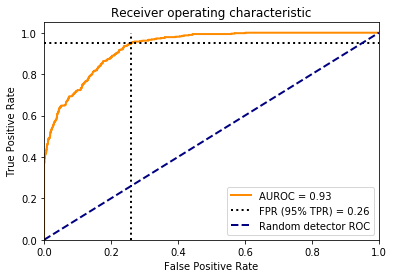


ODIN Kitti Train e=0.003800, T=1000


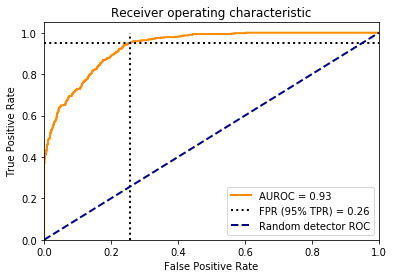


ODIN Kitti Train e=0.004000, T=1000


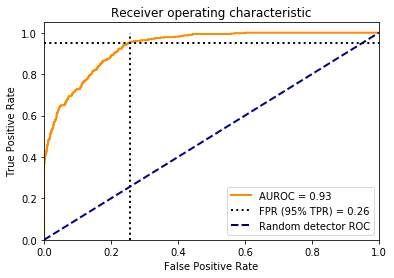

In [9]:
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_pert_%f_temp_%d.hdf5" % (eps, temp))

    if True:# and not os.path.exists(save_file):
        extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_file, eps, temp)
        
    print("ODIN Kitti Train e=%f, T=%d" % (eps, temp))
    kitti_train_X, kitti_train_y = read_scores(save_file)
    kitti_train_novelty_scores = -kitti_train_X
    plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y)

#### Kitti val

In [10]:
trainer.faster_rcnn.eval()
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

    if True:# and not os.path.exists(save_file):
        extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

    print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))
    kitti_val_X, kitti_val_y = read_scores(save_file)
    kitti_val_novelty_scores = -kitti_val_X
    calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y)


ODIN Kitti Val e=0.000000, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret =

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaco

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "<ipython-input-10-986794116ba2>", line 6, in <module>
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<ipython-input-10-986794116ba2>", line 6, in <module>
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python

  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 150, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packa

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3

  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
Message: 'WARNI

Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '2bb0d0af-f49ccc0e0bbc3ab1c8a0f7e2', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '010ccc70-41e494d4b4a7e93ffd05445c', 'date': datetime.datetime(2019, 11, 29, 5, 52, 36, 941258, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '2bb0d0af-f49ccc0e0bbc3ab1c8a0f7e2', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b0da57b018e841b889dd85c8f07cfabc', 'username': 'username', 'session': 'a828e93703e640d5852df7f789fd4555', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 11, 29, 5, 39, 28, 833179, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 3578/3578 [00:04&lt;00:00, 865.07it/s]'}, 'buffer_paths': []}, 'comm_id': '350269f5380e4e18bd847ffed5c8f2fb'}, 'metadata': {}}
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "


ODIN Kitti Val e=0.000200, T=1000



ODIN Kitti Val e=0.000400, T=1000



ODIN Kitti Val e=0.000600, T=1000



ODIN Kitti Val e=0.000800, T=1000



ODIN Kitti Val e=0.001000, T=1000



ODIN Kitti Val e=0.001200, T=1000



ODIN Kitti Val e=0.001400, T=1000



ODIN Kitti Val e=0.001600, T=1000



ODIN Kitti Val e=0.001800, T=1000



ODIN Kitti Val e=0.002000, T=1000



ODIN Kitti Val e=0.002200, T=1000



ODIN Kitti Val e=0.002400, T=1000



ODIN Kitti Val e=0.002600, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/l

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
Call stack:
Traceback (most recent call last):
Call stack:
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init_

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-pack

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", l

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 32

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 128, in _run_after_forkers
    items = list(_afterfork_registry.items())
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 128, in _run_after_forkers
    items = list(_afterfork_registry.items())
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/weakref.py", line 217, in items
    yield k, v
  File "<ipython-input-10-986794116ba2>", line 6, in <module>
    extract_kitti_features(kitti_val_dataset, trainer.faster

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 128, in _run_after_forkers
    items = list(_afterfork_registry.items())
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '17f86b4c-3cf9f4a6859946b3eab13c09', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '010ccc70-41e494d4b4a7e93ffd05445c', 'date': datetime.datetime(2019, 11, 29, 10, 52, 25, 237669, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '17f86b4c-3cf9f4a6859946b3eab13c09', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b0da57b018e841b889dd85c8f07cfabc', 'username': 'username', 'session': 'a828e93703e640d5852df7f789fd4555', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 11, 29, 5, 39, 28, 833179, tzinfo=datetime.timezone

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupy


ODIN Kitti Val e=0.002800, T=1000


--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
BrokenPipeError: [Errno 32] Broken pipe
--- Logging error ---
Call stack:
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
B

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
   

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nod

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 128, in _run_after_forkers
    items = list(_afterfork_registry.items())
  File "/home/t

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __se

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 128, in _run_after_forkers
    items = list(_afterfork_registry.items())
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/pytho


ODIN Kitti Val e=0.003000, T=1000



ODIN Kitti Val e=0.003200, T=1000



ODIN Kitti Val e=0.003400, T=1000


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/li

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 285

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "<ipython-input-10-986794116ba2>", line 6, in <module>
    extract_kitti_features(

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/pr

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/s

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 980, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/ImageSequence.py", line 55, in Iterator
    def next(self):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3

Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'cbe0ee95-0fbc77c14bbf835284120f7d', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '010ccc70-41e494d4b4a7e93ffd05445c', 'date': datetime.datetime(2019, 11, 29, 12, 24, 45, 314467, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': 'cbe0ee95-0fbc77c14bbf835284120f7d', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': 'b0da57b018e841b889dd85c8f07cfabc', 'username': 'username', 'session': 'a828e93703e640d5852df7f789fd4555', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 11, 29, 5, 39, 28, 833179, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 3578/3578 [00:03&lt;00:00, 1100.38it/s]'}, 'buffer_paths': []}, 'comm_id': '8e00a31f3b78426999739b3e4d81bf72'}, 'metadata': {}}
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-

  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/ImagePalette.py", line 20, in <module>
    from . import ImageColor, GimpPaletteFile, GimpGradientFile, PaletteFile
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_remov


ODIN Kitti Val e=0.003600, T=1000



ODIN Kitti Val e=0.003800, T=1000



ODIN Kitti Val e=0.004000, T=1000


In [29]:
results = []

for eps, temp in tqdm(odin_params, total=len(odin_params)):
    save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

    kitti_val_X, kitti_val_y = read_scores(save_file)
    kitti_val_novelty_scores = -kitti_val_X
    
    results.append(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

In [30]:
best_params = np.argmin([x['fpr_at_95_tpr'] for x in results[1:]])
print("Best params:", odin_params[1:][best_params])

eps, temp = odin_params[1:][best_params]

Best params: (0.0004, 1000)


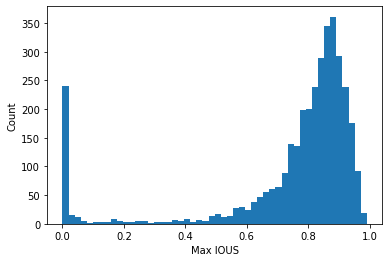

Total false positives (< 0.70) IoU: 723
Total detections: 3578
Total false positives (< 0.70) IoU: 20.206819%


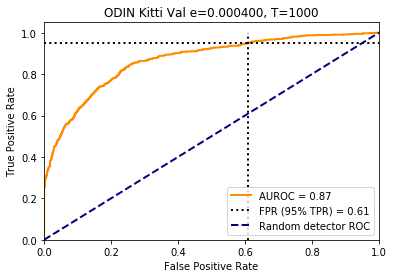

{'fpr_at_95_tpr': 0.6096106629252894, 'detection_error': 0.3295646161944191, 'auroc': 0.8679422794772171, 'aupr_in': 0.7139119668248137, 'aupr_out': 0.9543567605177643}


In [31]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

show_max_ious_dist(save_file)

kitti_val_X, kitti_val_y = read_scores(save_file)

kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="ODIN Kitti Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

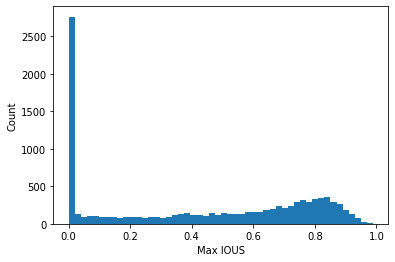

Total false positives (< 0.70) IoU: 6928
Total detections: 10225
Total false positives (< 0.70) IoU: 67.755501%


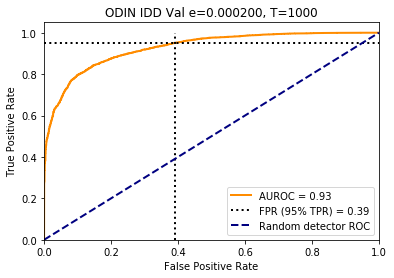

{'fpr_at_95_tpr': 0.39055520102105934, 'detection_error': 0.22023881895644704, 'auroc': 0.9261073138271665, 'aupr_in': 0.9665159113952502, 'aupr_out': 0.8514936095765534}


In [43]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

if True and not os.path.exists(save_file):
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

show_max_ious_dist(save_file)

idd_val_X, idd_val_y = read_scores(save_file)

idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="ODIN IDD Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

## Entropy

In [8]:
NUM_MC_PASSES = 10

def extract_kitti_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    model.train()
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores = res
            pred_bboxes, pred_labels, pred_scores = pred_bboxes[0], pred_labels[0], pred_scores[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            # Get additional MC Dropout class predictions
            pred_scores = [pred_scores]
            for j in range(NUM_MC_PASSES-1):
                res = model.predict(imgs, visualize=True)
                _, _, pred_scores_j = res
                pred_scores.append(pred_scores_j[0]) 

            d.create_dataset("pred_scores", data=pred_scores)  
    model.eval()
      
        
def extract_idd_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)

    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores = res
            pred_bboxes, pred_labels, pred_scores = pred_bboxes[0], pred_labels[0], pred_scores[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            # Get additional MC Dropout class predictions
            pred_scores = [pred_scores]
            for j in range(NUM_MC_PASSES-1):
                res = model.predict(imgs, visualize=True)
                _, _, pred_scores_j = res
                pred_scores.append(pred_scores_j[0]) 

            d.create_dataset("pred_scores", data=pred_scores)  
    model.eval()

#### Kitti Val

In [9]:
if False:
    save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
    extract_kitti_mc_softmax(kitti_val_dataset, trainer.faster_rcnn, save_file)

In [10]:
import mc_uncertainty as mcu


def read_mc_scores(save_file):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        for i in trange(len(f)):
            d = f[str(i)]
            features = d["pred_scores"][()]

            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=-1)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return np.moveaxis(np.stack((X, 1-X)), 0, 2), y

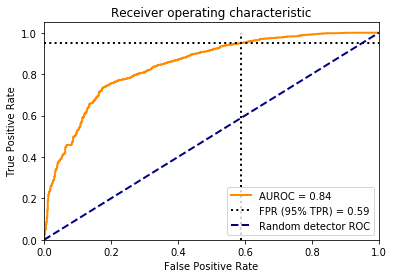

{'fpr_at_95_tpr': 0.5879120879120879, 'detection_error': 0.31886832465779835, 'auroc': 0.8430236649315597, 'aupr_in': 0.9476191567310783, 'aupr_out': 0.6348394919219006}


In [11]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = -mcu.predicted_entropy(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

#### IDD Val

In [12]:
if True:
    save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
    extract_idd_mc_softmax(idd_val_dataset, trainer.faster_rcnn, save_file)

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


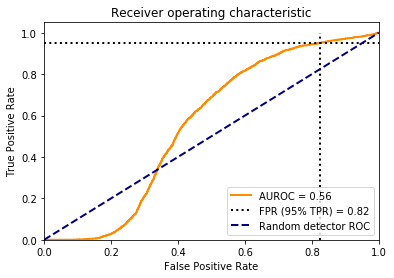

{'fpr_at_95_tpr': 0.8237450648618161, 'detection_error': 0.4367502104932861, 'auroc': 0.5571826817087681, 'aupr_in': 0.3023692266066513, 'aupr_out': 0.7759366633660464}


In [13]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = -mcu.predicted_entropy(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

## Mutual Information

#### Kitti Val

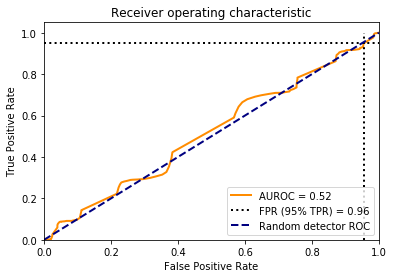

{'fpr_at_95_tpr': 0.9559167684167684, 'detection_error': 0.4957634470792366, 'auroc': 0.5161671004434162, 'aupr_in': 0.8019596097396834, 'aupr_out': 0.2123274756970832}


In [14]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = mcu.mutual_information(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

#### IDD Val

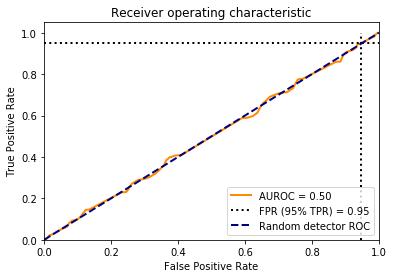

{'fpr_at_95_tpr': 0.9480614231392027, 'detection_error': 0.49874250851829466, 'auroc': 0.4995515597385977, 'aupr_in': 0.3075554408864126, 'aupr_out': 0.6932929699563493}


In [15]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = mcu.mutual_information(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

# Extended Feature Extractor Set

### Bind a feature extractor function to the model

In [23]:
model = trainer.faster_rcnn

@nograd
def get_all_features(self, imgs, visualize=False):
    self.eval()
    if visualize:
        prepared_imgs = list()
        for img in imgs:
            img = preprocess(at.tonumpy(img))
            prepared_imgs.append(img)
    else:
         prepared_imgs = imgs 

    for img in prepared_imgs:
        img = at.totensor(img[None], cuda=True).float()
        features = [img]
        
        for l in self.extractor:
            features.append(l(features[-1]))
        
        # Detach all features from GPU
        features = [at.tonumpy(f) for f in features]
        # Remove the first feature (ie the image)
        features = features[1:]
        # Average the features over the final two dimensions
        features = [np.mean(f, axis=(2,3)).squeeze(axis=0) for f in features]
        return features
    
model.get_all_features = get_all_features.__get__(model)

### Get the GT features

In [27]:
dataset_percentage = 0.2

# Make small train set
kitti_samples_train = round(len(kitti_train_dataset) * dataset_percentage)
kitti_to_use_train = np.random.choice(kitti_samples_train, kitti_samples_train, replace=False)
kitti_train_dataset_subset = torch.utils.data.Subset(kitti_train_dataset, kitti_to_use_train)

# Make small val set
kitti_samples_val = round(len(kitti_val_dataset) * dataset_percentage)
kitti_to_use_val = np.random.choice(kitti_samples_val, kitti_samples_val, replace=False)
kitti_val_dataset_subset = torch.utils.data.Subset(kitti_val_dataset, kitti_to_use_val)

In [26]:
dataset_percentage = 0.2

# Make small train set
kitti_samples_train = round(len(kitti_train_dataset) * dataset_percentage)
kitti_to_use_train = np.random.choice(kitti_samples_train, kitti_samples_train, replace=False)
kitti_train_dataset_subset = torch.utils.data.Subset(kitti_train_dataset, kitti_to_use_train)

# Make small val set
kitti_samples_val = round(len(kitti_val_dataset) * dataset_percentage)
kitti_to_use_val = np.random.choice(kitti_samples_val, kitti_samples_val, replace=False)
kitti_val_dataset_subset = torch.utils.data.Subset(kitti_val_dataset, kitti_to_use_val)


def extract_extended_kitti_features_gt(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            cars_bboxes = gt_bboxes[gt_labels == 0]
            
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(cars_bboxes):
                d_car = d.create_group("gt_bbox_"+str(j))
                y1, x1, y2, x2 = box.type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]
                
                # Check correct sections of image are extracted
                # plt.imshow(np.moveaxis(np.squeeze(at.tonumpy(im), axis=0), 0, 2).astype(np.int))
                # plt.show()
                
                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_car.create_dataset("extended_feat_"+str(k), data=feats)

if False:
    extract_extended_kitti_features_gt(kitti_train_dataset_subset, trainer.faster_rcnn, os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5"))

In [29]:
def extract_extended_kitti_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            res = model.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            preds = d.create_group('pred')
            preds.create_dataset("pred_boxes", data=pred_bboxes)
            preds.create_dataset("pred_scores", data=pred_scores)
            preds.create_dataset("pred_labels", data=pred_labels)
            preds.create_dataset("pred_num_detections", data=len(pred_bboxes))
            preds.create_dataset("pred_max_ious", data=max_ious) 
            preds.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                preds.create_dataset("pred_features_" + str(j), data=feats)
                
            bboxes = d.create_group('bboxes')
            # Get the extended feature set from the cropped bbox sections
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(at.totensor(pred_bboxes)):
                d_box = bboxes.create_group(str(j))
                y1, x1, y2, x2 = box.round().type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]

                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_box.create_dataset("extended_feat_"+str(k), data=feats)
                    
                    
def extract_extended_idd_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            preds = d.create_group('pred')
            preds.create_dataset("pred_boxes", data=pred_bboxes)
            preds.create_dataset("pred_scores", data=pred_scores)
            preds.create_dataset("pred_labels", data=pred_labels)
            preds.create_dataset("pred_num_detections", data=len(pred_bboxes))
            preds.create_dataset("pred_max_ious", data=max_ious) 
            preds.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                preds.create_dataset("pred_features_" + str(j), data=feats)
                
            bboxes = d.create_group('bboxes')
            # Get the extended feature set from the cropped bbox sections
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(at.totensor(pred_bboxes)):
                d_box = bboxes.create_group(str(j))
                y1, x1, y2, x2 = box.round().type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]

                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                for k, feats in enumerate(features):
                    d_box.create_dataset("extended_feat_"+str(k), data=feats)
                    
if False:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
    extract_extended_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

if False:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended_subset.hdf5")
    extract_extended_kitti_features(kitti_val_dataset_subset, trainer.faster_rcnn, save_path)
    
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
    extract_extended_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

if False:
    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
    extract_extended_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

## Train multiple SVM classifiers

In [31]:
# Train a one-class SVM networks with those features
GT_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5")
KITTI_TRAIN_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
IDD_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
NUM_EXTENDED_FEATURES = 30

def read_gt_extended_features(file, feature_idx):
    features = None
    
    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]
            
            for gt_bbox in im.keys():
                gt_bbox = im[gt_bbox]
                feats = gt_bbox["extended_feat_%d" % feature_idx]

                if features is None:
                    features = np.expand_dims(feats, axis=0)
                else:
                    features = np.concatenate((features, np.expand_dims(feats, axis=0)), axis=0)
    
    return features


def read_extended_features(file, feature_idx):
    features = None
    labels = np.empty((0,))

    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]
            
            # Get the correctness labels
            label_is_car = im['pred']["pred_labels"][()] == 0
            iou_is_high_enough = im['pred']["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = im['pred']["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            labs = 1 - (label_is_car & iou_is_high_enough & classification_is_correct)
            labels = np.concatenate((labels, labs), axis=0)

            # Get the required features
            for j in im['bboxes'].keys():
                gt_bbox = im['bboxes'][j]
                feats = gt_bbox["extended_feat_%d" % feature_idx]

                if features is None:
                    features = np.expand_dims(feats, axis=0)
                else:
                    features = np.concatenate((features, np.expand_dims(feats, axis=0)), axis=0)
    
    return features, labels

# Train all the classifiers
def train_osvm(nu, gamma, kernel, train_features, one_class_save_path):
        # Train one class SVM
        clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
        clf.fit(train_features)

        # Save classifier
        with open(one_class_save_path, 'wb') as f:
            pickle.dump(clf, f)

NUS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
# GAMMAS = ['auto', 'scale']
GAMMAS = ['auto']
# KERNELS = ['rbf', 'linear']
KERNELS = ['rbf']

train_args = list(itertools.product(NUS, GAMMAS, KERNELS))

if False:
    for i in trange(NUM_EXTENDED_FEATURES):
        features_gt = read_gt_extended_features(GT_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            train_osvm(nu, gamma, kernel, features_gt, save_path)

In [32]:
if False:
    kitti_val_results = []

    for i in trange(NUM_EXTENDED_FEATURES):

        # Load the kitti val features
        kitti_val_X, kitti_val_y = read_extended_features(KITTI_VAL_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            # Load the classifier
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            with open(save_path, 'rb') as f:
                clf = pickle.load(f)

            # Calculate performance metrics
            kitti_val_novelty_scores = -clf.decision_function(kitti_val_X)
            res = calc_metrics(kitti_val_novelty_scores, kitti_val_y.astype(np.int))

            res['nu'] = nu
            res['gamma'] = gamma
            res['kernel'] = kernel
            res['features'] = i
            res['model'] = save_path

            kitti_val_results.append(res)

    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/kitti_val_results.pickle'), 'wb') as f:
        pickle.dump(kitti_val_results, f)

else:
    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/kitti_val_results.pickle'), 'rb') as f:
        kitti_val_results = pickle.load(f)

In [33]:
if False:
    idd_val_results = []

    for i in trange(NUM_EXTENDED_FEATURES):
        # Load the idd_val features
        idd_val_X, idd_val_y = read_extended_features(IDD_VAL_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            # Load the classifier
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            with open(save_path, 'rb') as f:
                clf = pickle.load(f)

            # Calculate performance metrics
            idd_val_novelty_scores = -clf.decision_function(idd_val_X)
            res = calc_metrics(idd_val_novelty_scores, idd_val_y.astype(np.int))

            res['nu'] = nu
            res['gamma'] = gamma
            res['kernel'] = kernel
            res['features'] = i
            res['model'] = save_path

            idd_val_results.append(res)

    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/idd_val_results.pickle'), 'wb') as f:
        pickle.dump(idd_val_results, f)
    
else:
    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/idd_val_results.pickle'), 'rb') as f:
        idd_val_results = pickle.load(f)

In [34]:
best_params = np.argmin([k['detection_error'] for k in kitti_val_results])
# best_params = np.argmax([k['aupr_in'] for k in kitti_val_results])

print(best_params)
print(kitti_val_results[best_params])

188
{'fpr_at_95_tpr': 0.8203508771929825, 'detection_error': 0.434900713321766, 'auroc': 0.6548187777135146, 'aupr_in': 0.3365875070727783, 'aupr_out': 0.8752853605147544, 'nu': 0.01, 'gamma': 'auto', 'kernel': 'rbf', 'features': 23, 'model': './idd_car_drop_checkpoints/one_class_models/kitti-one-class-extended-feat23-nu0.0100-gammaauto-kernelrbf.pickle'}


In [35]:
# best_params = np.argmin([k['fpr_at_95_tpr'] for k in idd_val_results])
# best_params = np.argmax([k['aupr_in'] for k in idd_val_results])

print(idd_val_results[best_params])

{'fpr_at_95_tpr': 0.9543568464730291, 'detection_error': 0.49799385541429053, 'auroc': 0.5398648720415049, 'aupr_in': 0.7310636925371525, 'aupr_out': 0.3190990274618077, 'nu': 0.01, 'gamma': 'auto', 'kernel': 'rbf', 'features': 23, 'model': './idd_car_drop_checkpoints/one_class_models/kitti-one-class-extended-feat23-nu0.0100-gammaauto-kernelrbf.pickle'}


### TODO:

- ~~Make a Pytorch dataset class for IDD~~
- ~~Train SVM models with extracted features~~
- ~~Improve data structure for saving features~~
    - ~~Less space requirement via hdf5 dataset per image~~

- ~~Resolve bi-modal kitti max IOU (bug? wrong loader? BG class?)~~
- ~~(Nov 23) Results for max softmax~~
- ~~(Nov 23) Results for Mahalanobis~~
- ~~(Nov 25) Results for an extended feature set classifier~~
- ~~(Nov 26) Test various SVM parameters to maximize performance (See Vahdat's paper)~~
- ~~ODIN~~
- Mahalanobis with input perturbation
- ~~Cars model (Use dropout)~~
- ~~Entropy / Mutual Information~~
- Performance metric that accounts for eliminated boxes and AP simultaneously
- Runtime statistics for a single prediction for each method

Ideas: 
    
    - Get rid of ignore index in crossentropy function in perturbation function
    -Increase the minimum IOU to be considered a good prediction

## Mahalanobis with input perturbation

In [33]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
temperatures = np.array([1000])

epsilons = np.linspace(0, 0.004, 21)
# epsilons = np.array([0.0034])

odin_params = list(itertools.product(epsilons, temperatures))

Build a Mahalanobis model for each of train eps and temp

In [34]:
if False:
    for eps, temp in tqdm(odin_params, total=len(odin_params)):
        save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_pert_%f_temp_%d.hdf5" % (eps, temp))
        kitti_train_X, kitti_train_y = read_features(save_file, 4)

        mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    
        # Take features from good detections only
        kitti_mahalanobis_features = kitti_train_X[kitti_train_y.astype(np.bool)]

        # Everything is labelled 0 because we're just doing single class detection
        kitti_mahalanobis_labels = np.zeros((len(kitti_mahalanobis_features)))

        md = Mahal_Dist(kitti_mahalanobis_features, kitti_mahalanobis_labels)
        md.save(mahal_model_name)

Get the best model based on the Kitti Val performance

In [35]:
results2 = []
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    # Get the data
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
    kitti_val_X, kitti_val_y = read_features(save_path, 4)
    
    # Load the model
    mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    md = Mahal_Dist.load(mahal_model_name)
    
    kitti_val_novelty_scores = md(kitti_val_X)
    results2.append(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

In [41]:
# Pick the best eps and temp

idx = np.argmin(x['fpr_at_95_tpr'] for x in results2[1:])
print(odin_params[1:][idx])

eps, temp = odin_params[1:][idx]

# Load the model
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
md = Mahal_Dist.load(mahal_model_name)

(0.0002, 1000)


#### Kitti Val

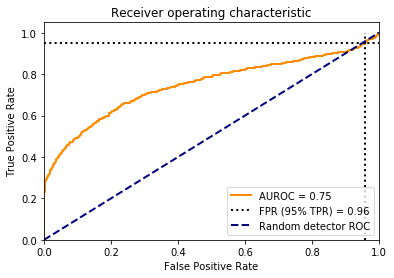

{'fpr_at_95_tpr': 0.958625525946704, 'detection_error': 0.4991234221598878, 'auroc': 0.7464468412288123, 'aupr_in': 0.6057925202931361, 'aupr_out': 0.8737824087078181}


In [37]:
# Get the data
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
kitti_val_X, kitti_val_y = read_features(save_path, 4)

kitti_val_novelty_scores = md(kitti_val_X)
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD Val

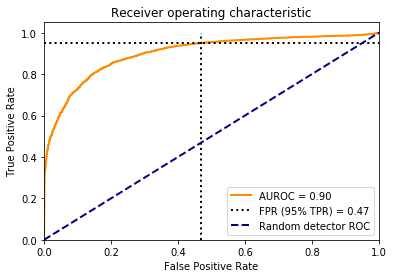

{'fpr_at_95_tpr': 0.46936821952776003, 'detection_error': 0.25950430437676963, 'auroc': 0.9015253162979183, 'aupr_in': 0.9557018341740516, 'aupr_out': 0.7464159078514865}


In [44]:
# Get the data
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
idd_val_X, idd_val_y = read_features(save_path, 4)

idd_val_novelty_scores = md(idd_val_X)
plot_roc(idd_val_novelty_scores, 1 - idd_val_y)
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))